In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import time
import random
import copy
import math

In [20]:
m=1000

M_v = 3000.976144195105 - -940.9125903639906
P_v = 2446.5858645842236 - 197.10793241368083
domestic_, industrial_, agricultural_= pd.read_csv('./water_usage.csv')['domestic'], pd.read_csv('./water_usage.csv')['industrial'], pd.read_csv('./water_usage.csv')['total']
B_ = pd.read_csv('./elec_usage.csv')['Elec Consumption(in billion kwh)']
N = int((M_v + P_v)/3.22321112134556)
bitlength = N.bit_length()
N_GENERATIONS=10000

Select 5 years' growth rate for simple demonstration
********************************************************************
*****************Case 1: Change A and B growth rate*****************
********************************************************************
A grows over 5 years


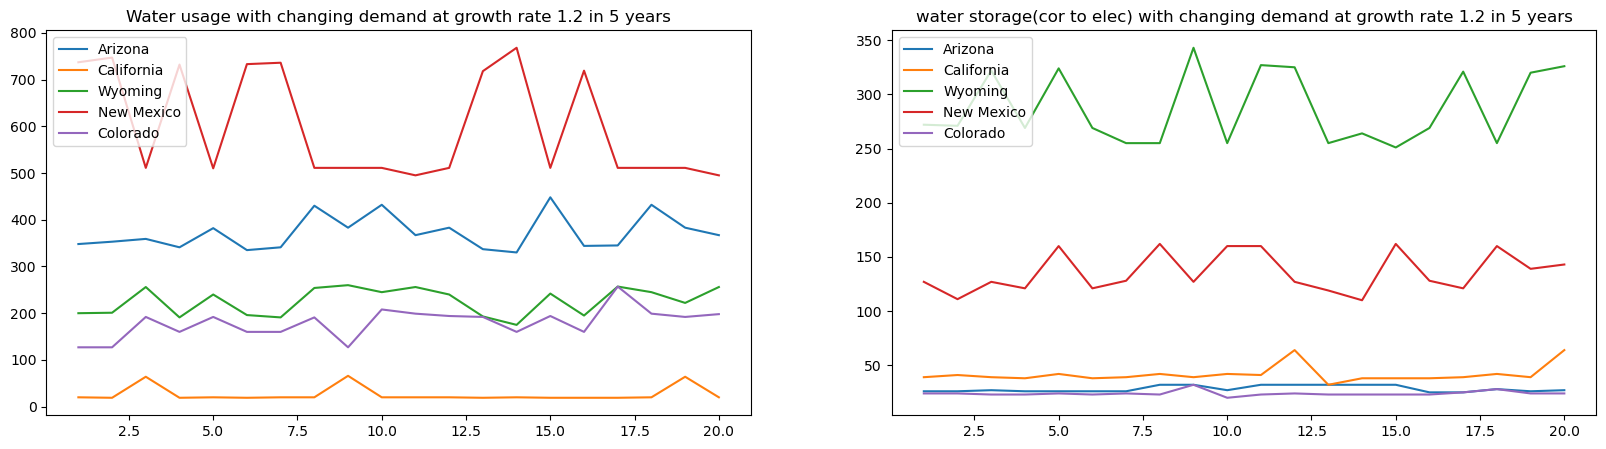

********************************************************************
A shrinks over 5 years


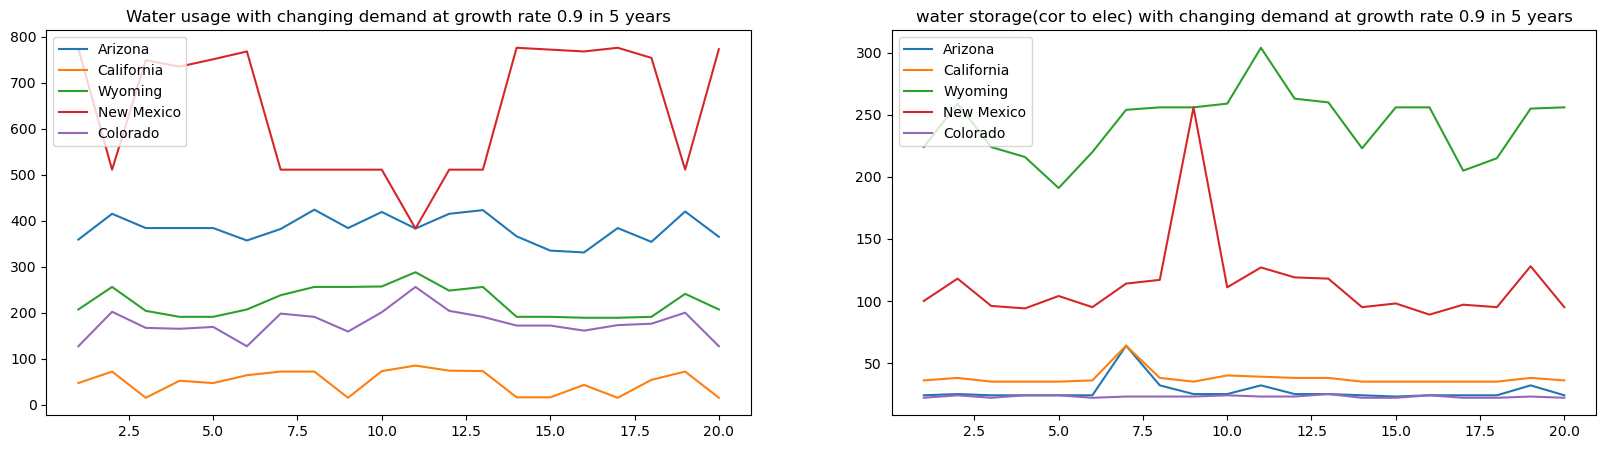

********************************************************************
B grows over 5 years


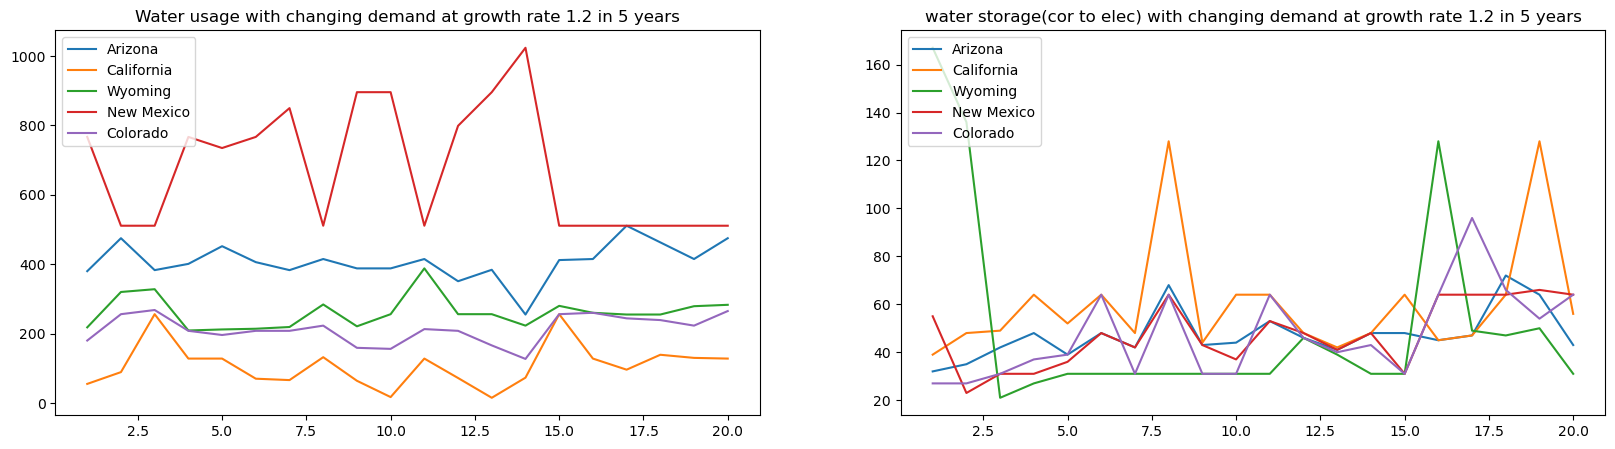

********************************************************************
B shrinks over 5 years


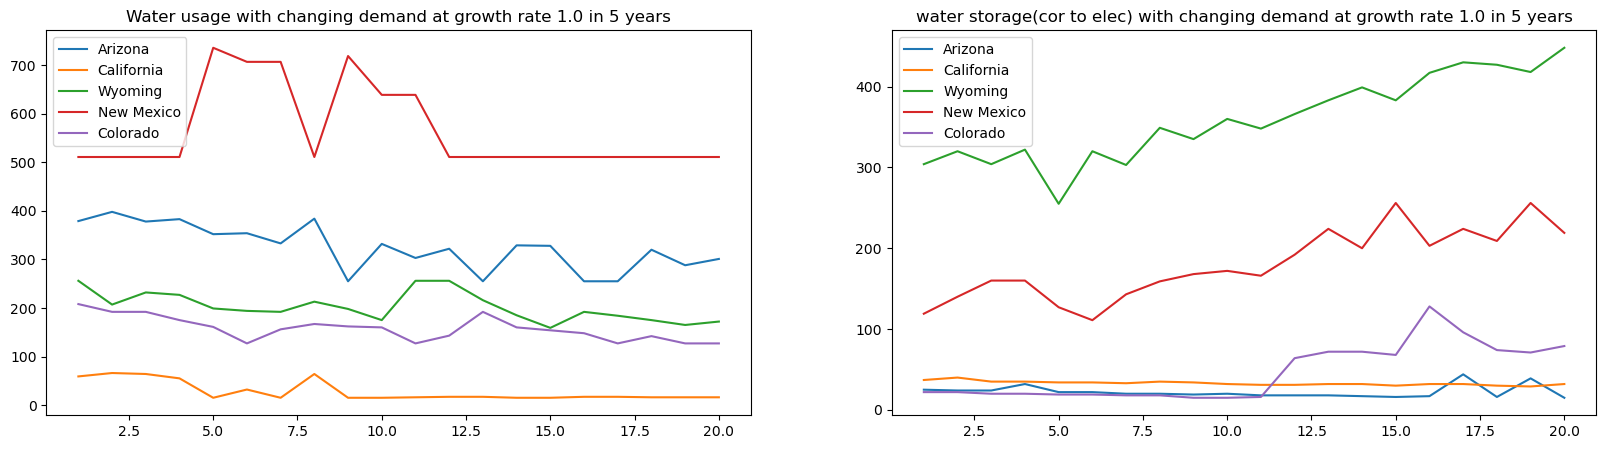

********************************************************************
population grows over 5 years


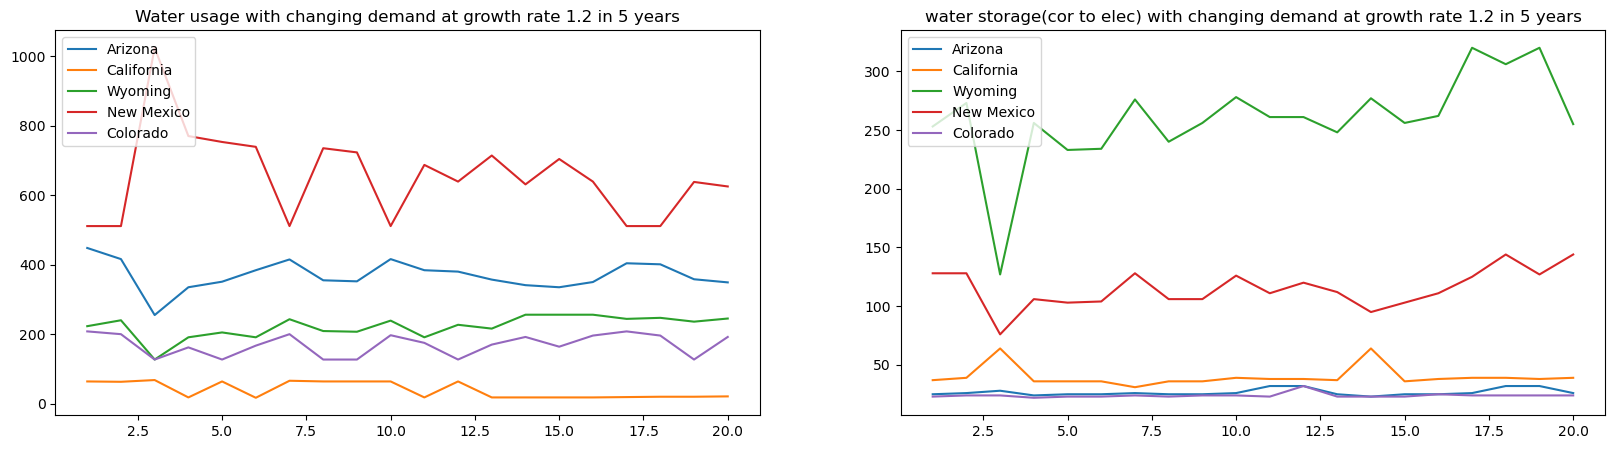

********************************************************************
population shrinks over 5 years


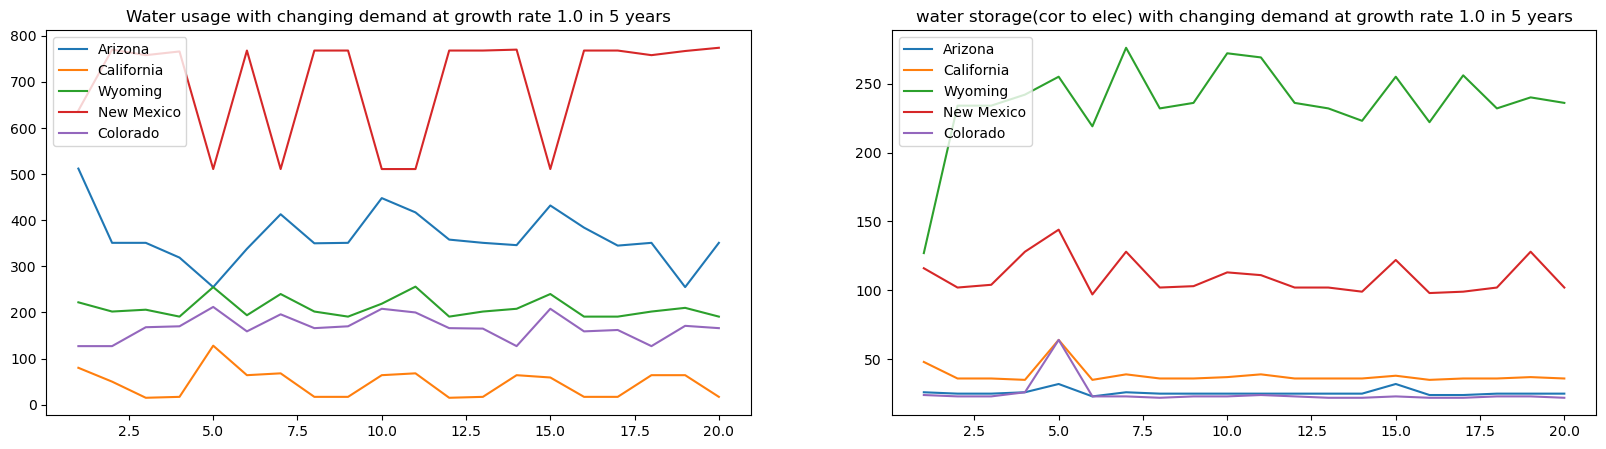

********************************************************************
agriculture grows over 5 years


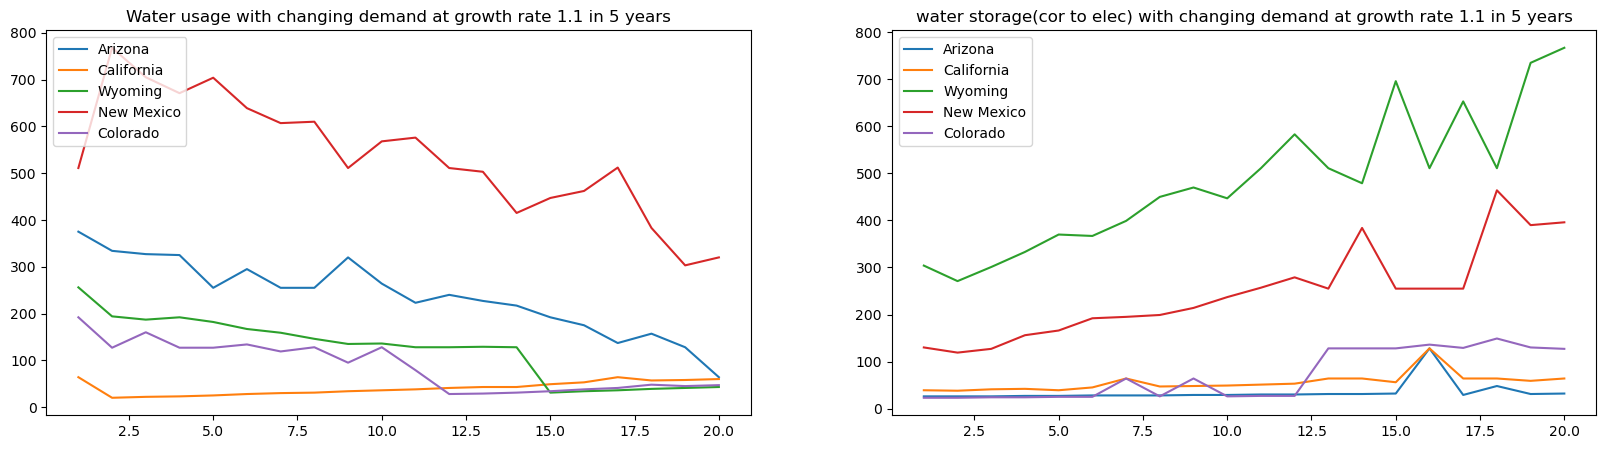

********************************************************************
agriculture shrinks over 5 years


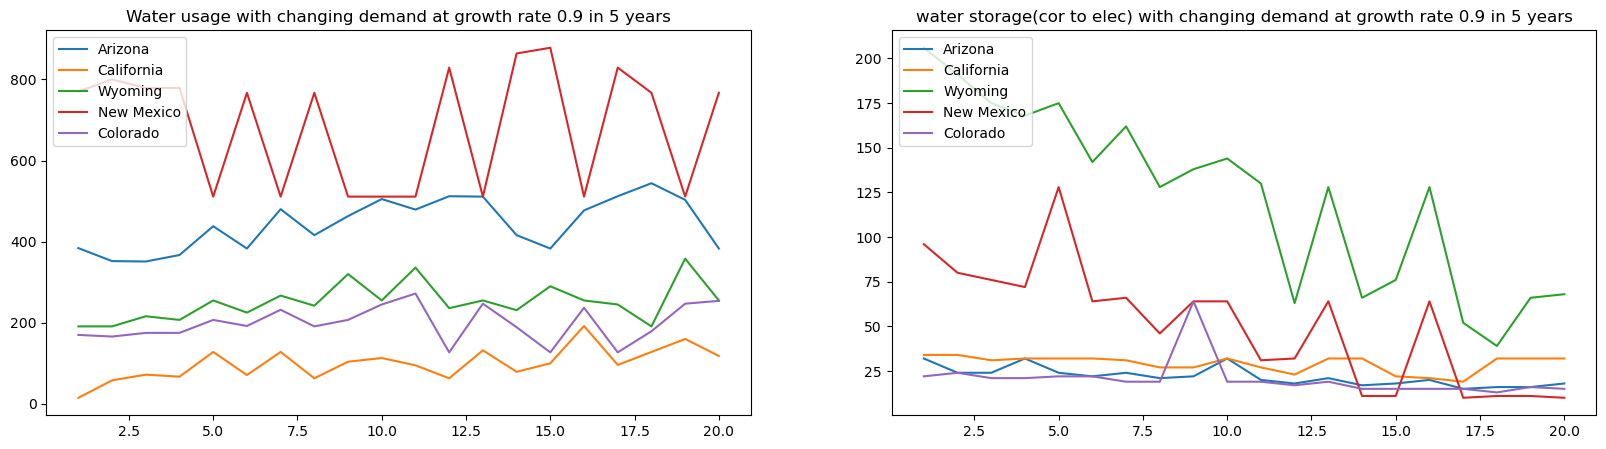

********************************************************************
industry grows over 5 years


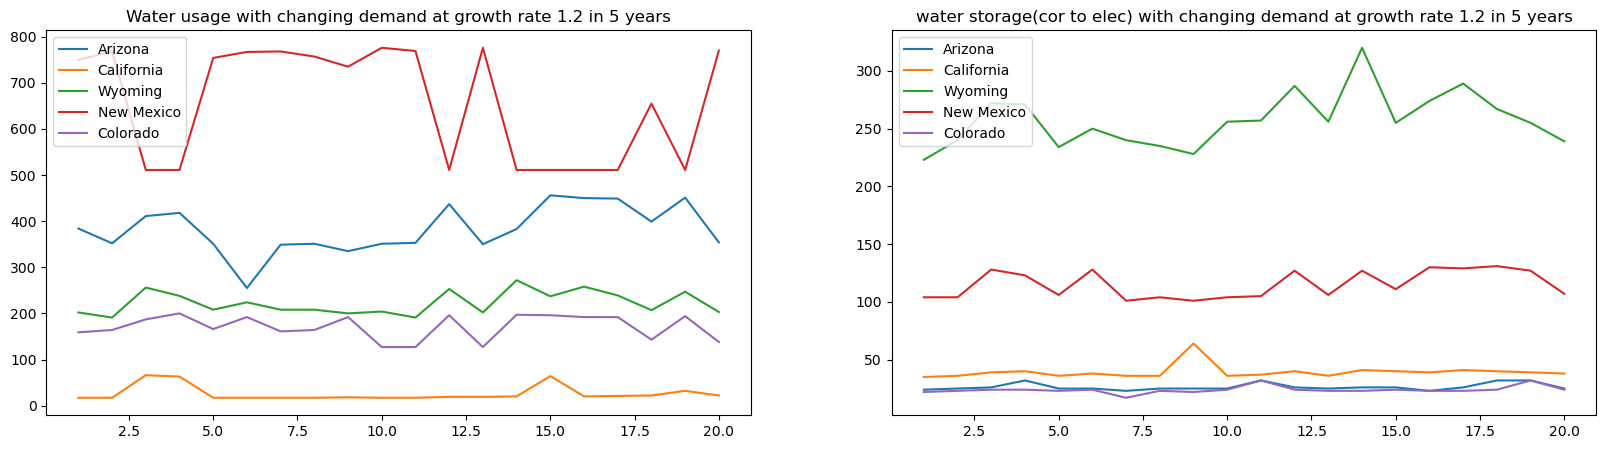

********************************************************************
industry shrinks over 5 years


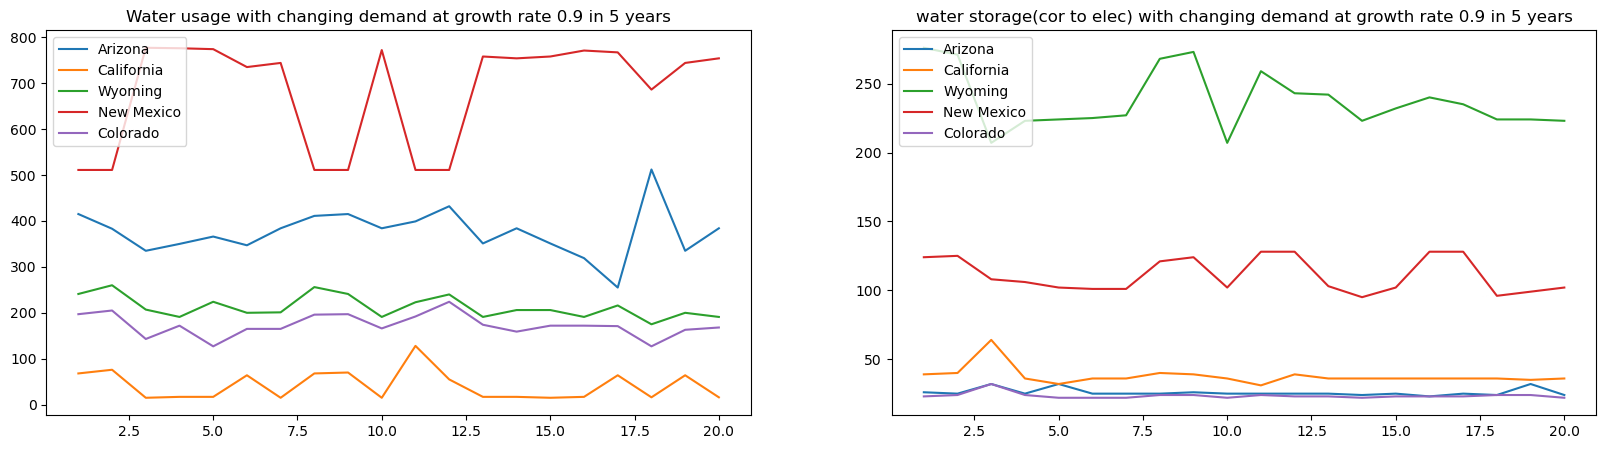

In [21]:

def e2w(y): return np.exp((y + 4.4675) / 1.1370)
def get_a_prime(A, B):
    ratio = B/sum(B)
    return np.append(A, e2w(np.sum(B)) * ratio)

def genetic_algorithm(a_prime, m, N):
    global bitlength, A, B, N_GENERATIONS
    def score(ai, a_primei, m):
        value = (m / a_primei - m / ai)**3
        return value

    def evaluate(a, a_prime, m):
        summation = 0
        for i in range(len(a)):
            summation = summation + score(a[i], a_prime[i], m)
        return summation / len(a)

    def init_random():
        x, tmp = [], []
        while len(tmp) < 9:
            r = random.randint(0, int(N))
            if r not in tmp and r != 0 and r != N:
                tmp.append(r)
        tmp.sort()
        x.append(tmp[0])
        for i in range(1, 9):
            x.append(tmp[i]-tmp[i-1])
        x.append(N-tmp[-1])
        return x

    def swap(x):
        new_x = copy.copy(x)
        x_copy = copy.copy(x)
        x = list(x)
        np.random.shuffle(x_copy)
        bitlength = int(N).bit_length()
        s = random.randint(0, bitlength-1)
        new_x[x.index(x_copy[0])] = int((bin(int(x_copy[0]))[2:]).zfill(bitlength)[:s] + bin(int(x_copy[1]))[2:].zfill(bitlength)[s:],2)
        new_x[x.index(x_copy[1])] = int(bin(int(x_copy[1]))[2:].zfill(bitlength)[:s] + bin(int(x_copy[0]))[2:].zfill(bitlength)[s:],2)
        return new_x

    def mutation(x):
        new_x = copy.copy(x)
        x_copy = copy.copy(x)
        ridx = random.randint(0, len(x_copy)-1)
        r = random.randint(0, bitlength-1)
        x_copy_bin = (bin(int(x_copy[ridx]))[2:]).zfill(bitlength)
        x_copy_bin = x_copy_bin[:r] + str((int(x_copy_bin[r])+1) % 2) + x_copy_bin[r+1:]
        new_x[ridx] = int(x_copy_bin, 2)
        return new_x

    def legal(x):
        if 0 in x:
            return False
        s = sum(x)
        if s > N:
            return False
        else:
            return True

    ## main part
    best_score = -999999
    next_x = init_random()
    best = next_x
    for _ in range(N_GENERATIONS):
        x = next_x
        y = swap(x)
        if not legal(y):
            y = x
        y_score = evaluate(y, a_prime, m)
        if y_score > best_score:
            best_score = y_score
            best = y
        z = mutation(y)
        if not legal(z):
            z = y
        z_score = evaluate(z, a_prime, m)
        if z_score > best_score:
            best_score = z_score
            best = z
        next_x = best
    best = np.array(best)
    return best, best_score, [score(best[i], a_prime[i], m) for i in range(len(best))]

def printResult(best, A_rate, B_rate, population_rate, agriculture_rate, industry_rate):
    print("--------------------")
    print("Under the following conditions:")
    print("A_rate, B_rate, population_rate, agriculture_rate, industry_rate = ", A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("The partition of water and electricity is: ", best)
    print("--------------------")
    return 

def lineChart(best_list_in_years, rate):
    fig, axis = plt.subplots(1,2,figsize=(20,5))
    best_list_in_years = np.array(best_list_in_years).T
    axis[0].title.set_text('Water usage with changing demand at growth rate %.1f in 5 years' % (rate))
    axis[0].plot(np.linspace(1, 20, 20), best_list_in_years[0], label='Arizona')
    axis[0].plot(np.linspace(1, 20, 20), best_list_in_years[1], label='California')
    axis[0].plot(np.linspace(1, 20, 20), best_list_in_years[2], label='Wyoming')
    axis[0].plot(np.linspace(1, 20, 20), best_list_in_years[3], label='New Mexico')
    axis[0].plot(np.linspace(1, 20, 20), best_list_in_years[4], label='Colorado')
    axis[0].legend(loc='upper left')
    axis[1].title.set_text('water storage(cor to elec) with changing demand at growth rate %.1f in 5 years' % (rate))
    axis[1].plot(np.linspace(1, 20, 20), best_list_in_years[5], label='Arizona')
    axis[1].plot(np.linspace(1, 20, 20), best_list_in_years[6], label='California')
    axis[1].plot(np.linspace(1, 20, 20), best_list_in_years[7], label='Wyoming')
    axis[1].plot(np.linspace(1, 20, 20), best_list_in_years[8], label='New Mexico')
    axis[1].plot(np.linspace(1, 20, 20), best_list_in_years[9], label='Colorado')
    axis[1].legend(loc='upper left')
    plt.show()
    return

def calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate):
    global domestic_, industrial_, agricultural_, A_, B_
    domestic, industrial, agricultural = domestic_/1e3, industrial_/1e3, agricultural_/1e3
    B = np.array(B_)/ 365
    best_list_in_years = []
    for year in range(20):
        domestic = domestic * population_rate
        industrial = industrial * industry_rate
        agricultural = agricultural * agriculture_rate
        A = domestic + industrial + agricultural
        A = A * A_rate
        B = B * B_rate
        a_prime = get_a_prime(A, B)
        m = 1
        best, best_score, score_list = genetic_algorithm(a_prime, m, N)
        # print("In year ", year+1)
        # printResult(best, A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
        best_list_in_years.append(best)
    return best_list_in_years

def main():
    # import 2019 data
    A_rate, B_rate, population_rate, agriculture_rate, industry_rate = 1, 1, 1, 1, 1
    global N, bitlength, A, B, N_GENERATIONS
    print("Select 5 years' growth rate for simple demonstration")
    print("********************************************************************")
    print("*****************Case 1: Change A and B growth rate*****************")
    ### A grows over 5 years
    A_rate = np.random.uniform(1.01, 1.25)
    B_rate = 1
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("A grows over 5 years")
    lineChart(best_list_in_years, A_rate)
    best_list_in_years.clear()
    ### A shrinks over 5 years
    A_rate = np.random.uniform(0.8, 1)
    B_rate = 1
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("A shrinks over 5 years")
    lineChart(best_list_in_years, A_rate)
    best_list_in_years.clear()
    ### B grows over 5 years
    A_rate = 1
    B_rate = np.random.uniform(1.01, 1.25)
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("B grows over 5 years")
    lineChart(best_list_in_years, B_rate)
    best_list_in_years.clear()
    ### B shrinks over 5 years
    A_rate = 1
    B_rate = np.random.uniform(0.8, 1)
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("B shrinks over 5 years")
    lineChart(best_list_in_years, B_rate)
    best_list_in_years.clear()
    ### population grows over 5 years
    A_rate, B_rate, population_rate, agriculture_rate, industry_rate = 1, 1, 1, 1, 1
    population_rate = np.random.uniform(1.01, 1.25)
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("population grows over 5 years")
    lineChart(best_list_in_years, population_rate)
    best_list_in_years.clear()
    ### population shrinks over 5 years
    A_rate, B_rate, population_rate, agriculture_rate, industry_rate = 1, 1, 1, 1, 1
    population_rate = np.random.uniform(0.8, 1)
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("population shrinks over 5 years")
    lineChart(best_list_in_years, population_rate)
    best_list_in_years.clear()
    ### agriculture grows over 5 years
    A_rate, B_rate, population_rate, agriculture_rate, industry_rate = 1, 1, 1, 1, 1
    agriculture_rate = np.random.uniform(1.01, 1.25)
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("agriculture grows over 5 years")
    lineChart(best_list_in_years, agriculture_rate)
    best_list_in_years.clear()
    ### agriculture shrinks over 5 years
    A_rate, B_rate, population_rate, agriculture_rate, industry_rate = 1, 1, 1, 1, 1
    agriculture_rate = np.random.uniform(0.8, 1)
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("agriculture shrinks over 5 years")
    lineChart(best_list_in_years, agriculture_rate)
    best_list_in_years.clear()
    ### industry grows over 5 years
    A_rate, B_rate, population_rate, agriculture_rate, industry_rate = 1, 1, 1, 1, 1
    industry_rate = np.random.uniform(1.01, 1.25)
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("industry grows over 5 years")
    lineChart(best_list_in_years, industry_rate)
    best_list_in_years.clear()
    ### industry shrinks over 5 years
    A_rate, B_rate, population_rate, agriculture_rate, industry_rate = 1, 1, 1, 1, 1
    industry_rate = np.random.uniform(0.8, 1)
    best_list_in_years = calculateWater(A_rate, B_rate, population_rate, agriculture_rate, industry_rate)
    print("********************************************************************")
    print("industry shrinks over 5 years")
    lineChart(best_list_in_years, industry_rate)
    best_list_in_years.clear()
main()